In [4]:
import os
import sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import get_root_dir, set_seed, setup_gpu
from utils.data import load_data_with_test_split
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import plot_latent_space, plot_3d_latent_space_from_angles
from utils.evaluation import evaluate_autoencoder, ssim_loss, ssim_l1_loss, dssim_loss, evaluate_autoencoder_with_distribution_threshold, evaluate_autoencoder_with_threshold_generator

In [5]:
# Hyperparameter to tune
config = {
    "comment" : "run with data augmentation",
    "epochs" : 100,
    "loss" : 'mse',
    "optimizer" : "adam",
    "dropout": True,
    "dropout_value" : 0.0,
    "rotation_range" : 90,
    "batch_size" : 16,
    "latent_dim" : 512,
    "threshold_percentage" : 80,
    "data_class" : "screw",
    "model_type" : "autoencoder"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [6]:
wandb.init(project="itu-aml-project", config=config)
config = wandb.config # this turns our hyperparameter config into a proper object with attributes

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jonathantiedchen (itu-aml-project). Use `wandb login --relogin` to force relogin


In [7]:
#root_dir = get_root_dir()
root_dir = 'Mini Project'

set_seed(1234)

model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

In [8]:
# train_generator, validation_generator, test_generator = load_data(category=config.data_class, batch_size=config.batch_size)

train_generator, validation_generator, test_generator, threshold_generator = load_data_with_test_split(
    category="screw",
    batch_size=32,
    test_split=0.4,
    rotation_range=config.rotation_range
)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 98 images belonging to 6 classes.
Found 62 images belonging to 6 classes.


In [9]:
def vanilla_autoencoder(input_shape=INPUT_SHAPE, optimizer='', latent_dim=512, loss='mse'):
    """
        input_shape (tuple): Shape of the input images (height, width, channels).
        latent_dim (int): Dimension of the latent space.
        loss (str): Loss used to train the autoencoder. Options: 'mse', 'ssim', etc.
    """
    # Encoder
    input_img = Input(shape=input_shape)

    # Encoder with reduced complexity
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (128, 128, 32)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (64, 64, 64)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (32, 32, 128)
    x = Dropout(0.3)(x)

    # Bottleneck
    x = Flatten()(x)  # Flattened Shape: (32 * 32 * 128,)
    encoded = Dense(latent_dim)(x)  # Latent space size reduced to 526
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU(name='bottleneck')(encoded)

    # Decoder with reduced complexity
    x = Dense(32 * 32 * 128)(encoded)
    x = Reshape((32, 32, 128))(x)

    x = UpSampling2D((2, 2))(x)  # (64, 64, 128)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (128, 128, 64)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (256, 256, 32)
    x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder Model
    autoencoder = Model(input_img, x)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return autoencoder

# get correct loss from config as functions are not callable from config itself
if config.loss == 'mae': loss = 'mae'
elif config.loss == 'mse': loss = 'mse'
elif config.loss == 'dssim_loss': loss = dssim_loss
elif config.loss == 'ssim_loss': loss = ssim_loss
elif config.loss == 'ssim_l1_loss': loss = ssim_l1_loss
else:
    raise ValueError(f"Unknown loss function: {config.loss}. Please define a function to calculate the error.")

print(f"Used Loss to train:{loss}")
print(f"Optimizer: {config.optimizer}")

autoencoder = vanilla_autoencoder(
    input_shape=INPUT_SHAPE, 
    optimizer=config.optimizer, 
    latent_dim=config.latent_dim, 
    loss=loss
)


print("Input shape:", autoencoder.input_shape)
print("Output shape:", autoencoder.output_shape)

autoencoder.summary()

Used Loss to train:mse
Optimizer: adam
Input shape: (None, 256, 256, 3)
Output shape: (None, 256, 256, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (LeakyReLU)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │    67,239,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             

 Total params: 134,539,011 (513.23 MB)

 Trainable params: 134,537,347 (513.22 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [10]:
#define early stopping and checkpoints
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=20, 
    start_from_epoch=20
    )

checkpoint = ModelCheckpoint(
    cpkt_path, 
    monitor="val_loss", 
    mode="min", 
    save_best_only=True, 
    verbose=1
    )

history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        early_stop,
        checkpoint,
        WandbMetricsLogger(),
        # WandbModelCheckpoint("models"), # Saves model checkpoint to W&B
    ],
)

wandb.finish()

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - loss: 0.0932
Epoch 1: val_loss improved from inf to 0.04790, saving model to Mini Project/models/autoencoder/logs/checkpoints/run with data augmentation_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0898 - val_loss: 0.0479
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - loss: 0.0190
Epoch 2: val_loss improved from 0.04790 to 0.03938, saving model to Mini Project/models/autoencoder/logs/checkpoints/run with data augmentation_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0186 - val_loss: 0.0394
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - loss: 0.0101
Epoch 3: val_loss improved from 0.03938 to 0.02603, saving model to Mini Project/models/autoencoder/logs/checkpoints/run with data augmentation_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0100 - val_loss: 0.0260
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - loss: 0.0073
Epoch 4: val_loss improved

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.00128
epoch/val_loss,0.00294


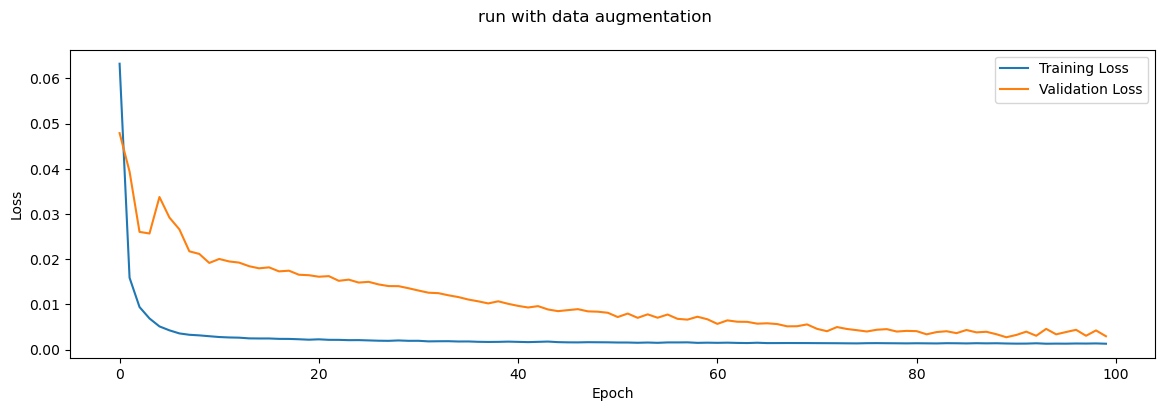

Best train_loss: 0.0013
Best val_loss: 0.0027
Last improvement of val_loss at epoch: 1


In [11]:
# plot the training history
plot_history(comment=config.comment, history=history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


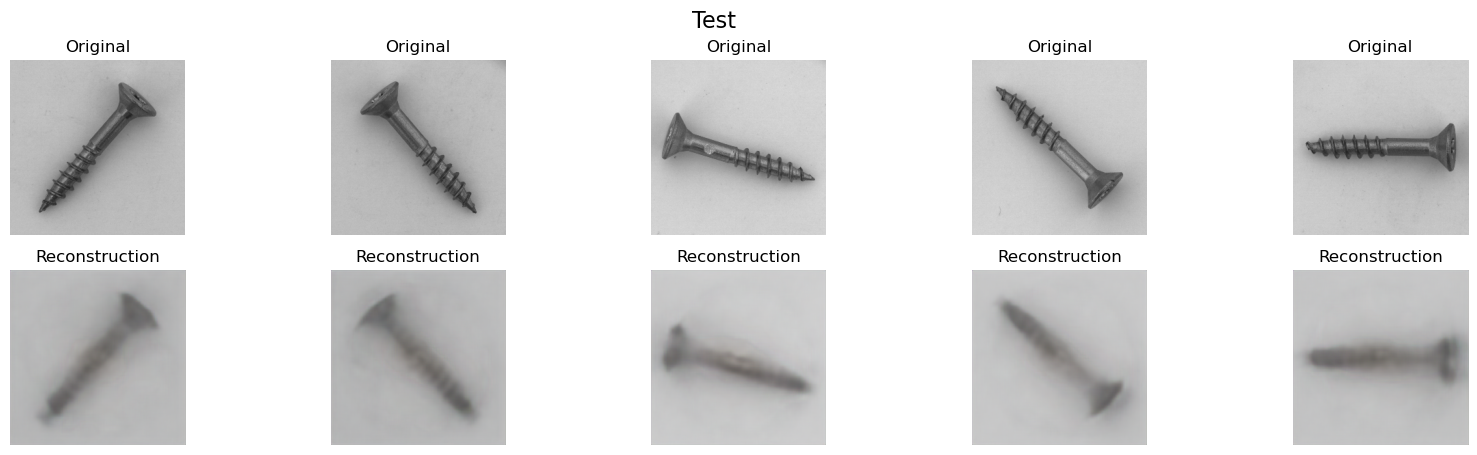

In [12]:
plot_reconstructions(autoencoder, test_generator, n_images=5, title='Test')


## Evaluate with Reconstruction Error

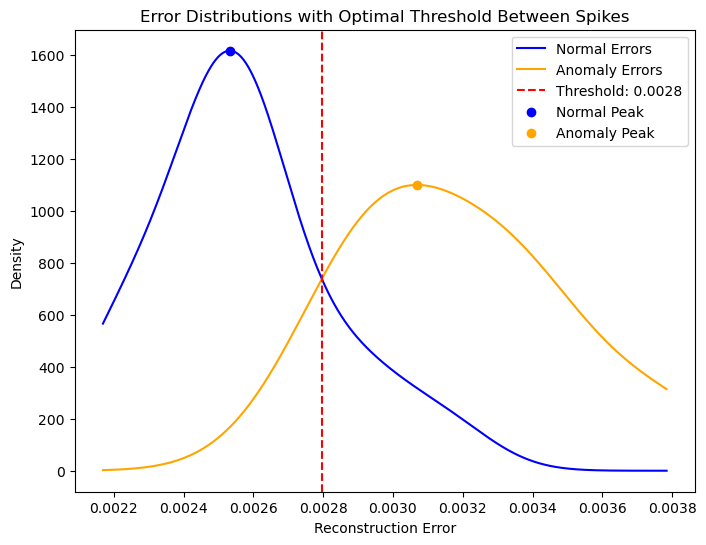

Optimal Threshold: 0.0028
              precision    recall  f1-score   support

      Normal       0.76      0.88      0.81        25
     Anomaly       0.96      0.90      0.93        73

    accuracy                           0.90        98
   macro avg       0.86      0.89      0.87        98
weighted avg       0.91      0.90      0.90        98



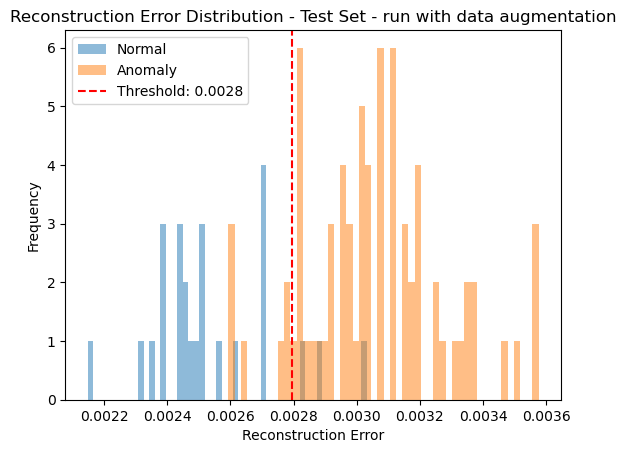

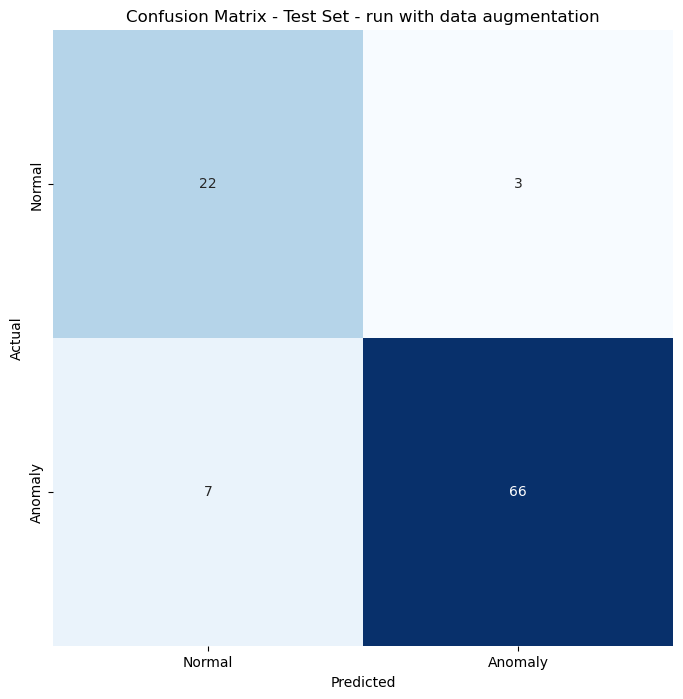

In [13]:
# sampling generated from flow
evaluate_autoencoder_with_threshold_generator(
    autoencoder=autoencoder,
    test_generator=test_generator,
    threshold_generator=threshold_generator,
    config=config
)

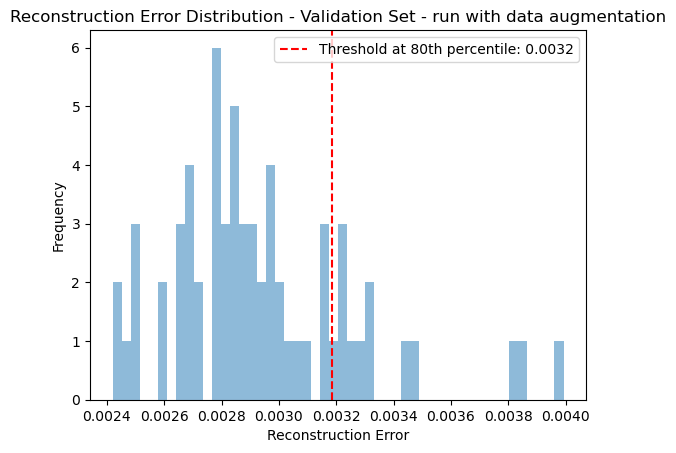

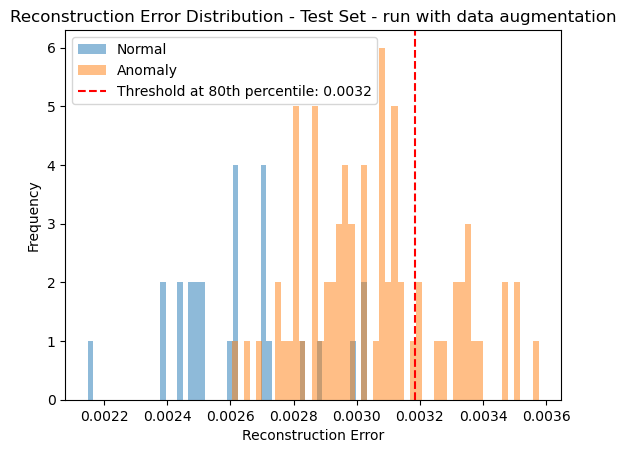

              precision    recall  f1-score   support

      Normal       0.33      1.00      0.49        26
     Anomaly       1.00      0.25      0.40        72

    accuracy                           0.45        98
   macro avg       0.66      0.62      0.45        98
weighted avg       0.82      0.45      0.42        98



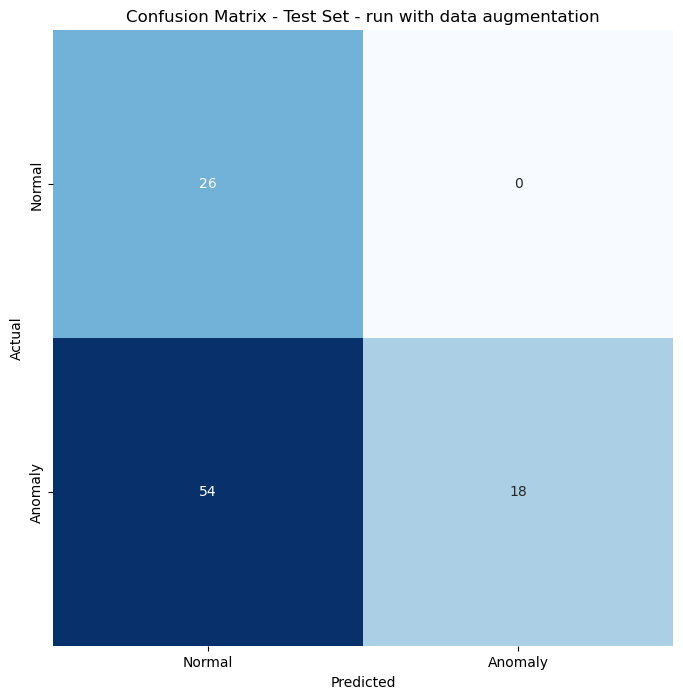

In [14]:
#without threshhold setting via distribution
import importlib
import utils.evaluation

# Reload the module to get updated functions
importlib.reload(utils.evaluation)
from utils.evaluation import evaluate_autoencoder
evaluate_autoencoder(
    config = config,
    autoencoder=autoencoder,
    validation_generator=validation_generator,
    test_generator=test_generator
    )

## Evaluate with Latent Space

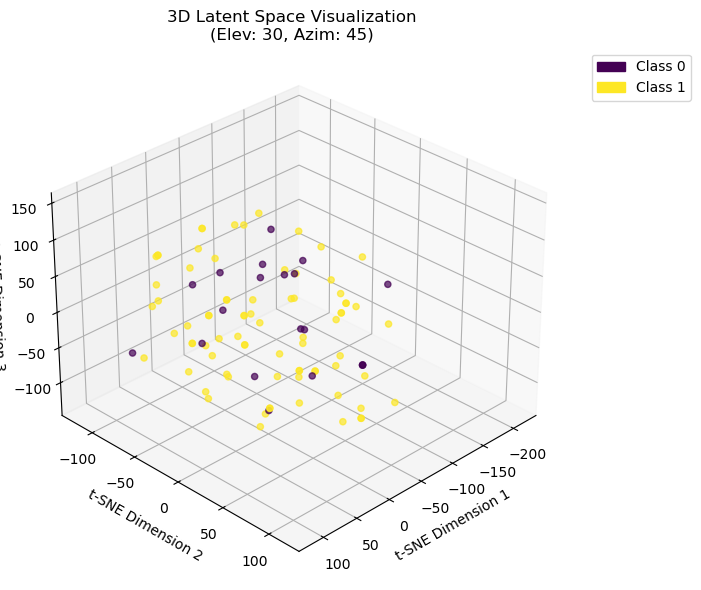

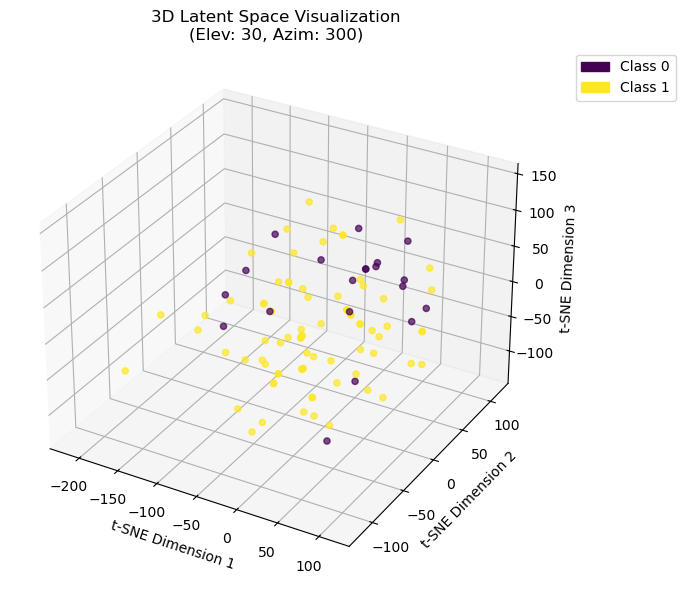

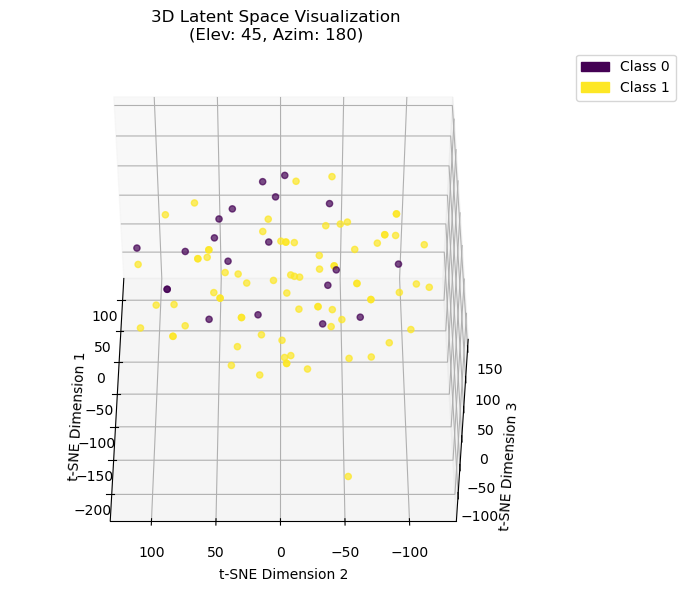

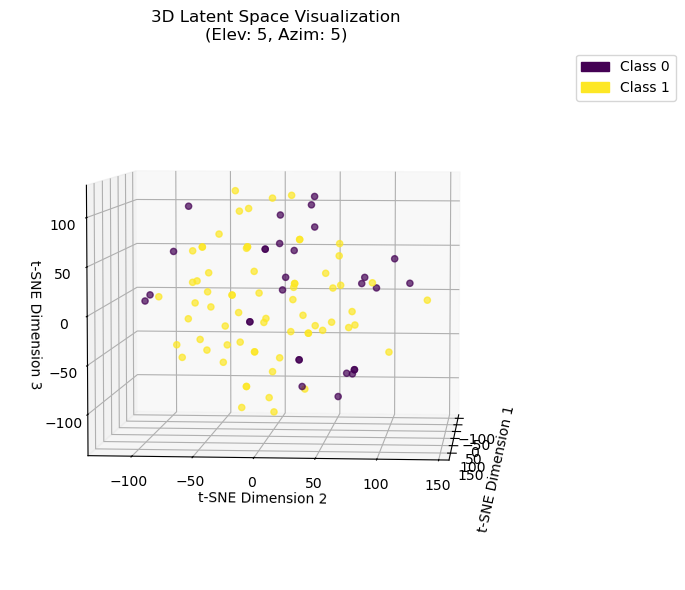

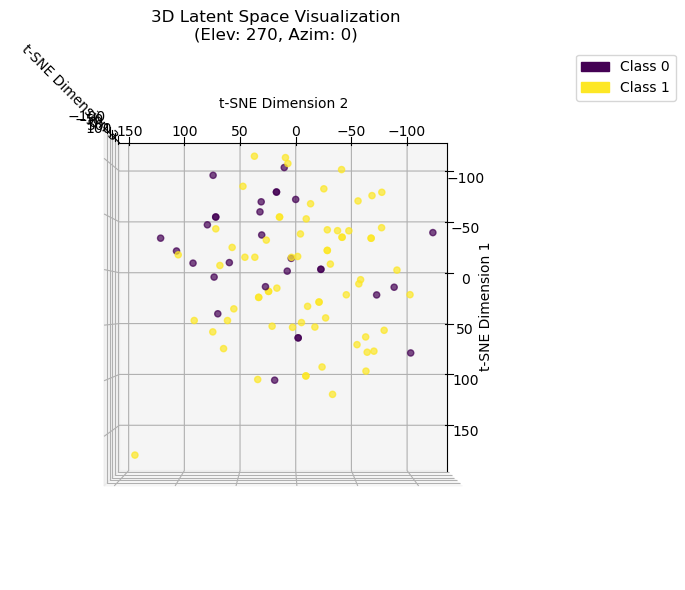

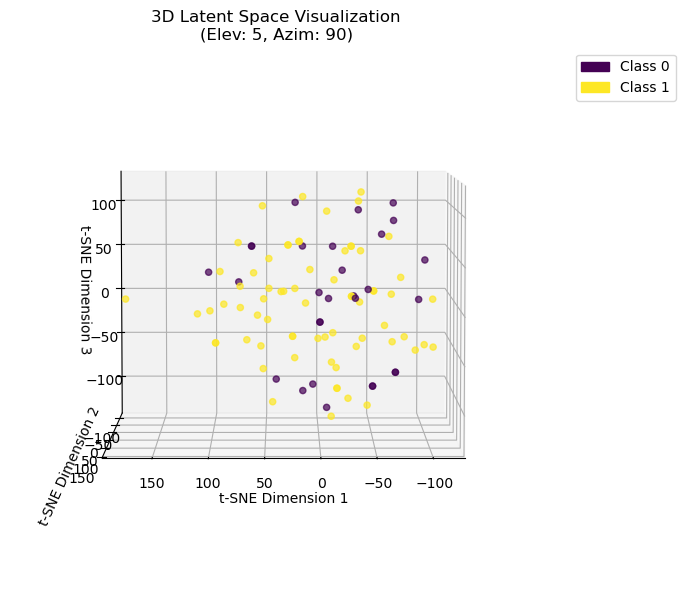

In [46]:
angles_1 = [(30, 45), (30, 300), (45, 180)]  # Define viewing angles
plot_3d_latent_space_from_angles(autoencoder, test_generator, angles=angles_1)

angles_2 = [(5, 5), (270, 0), (5, 90)]  # Define viewing angles
plot_3d_latent_space_from_angles(autoencoder, test_generator, angles=angles_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Threshold Value (Percentile 80%): 11.142606735229492
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


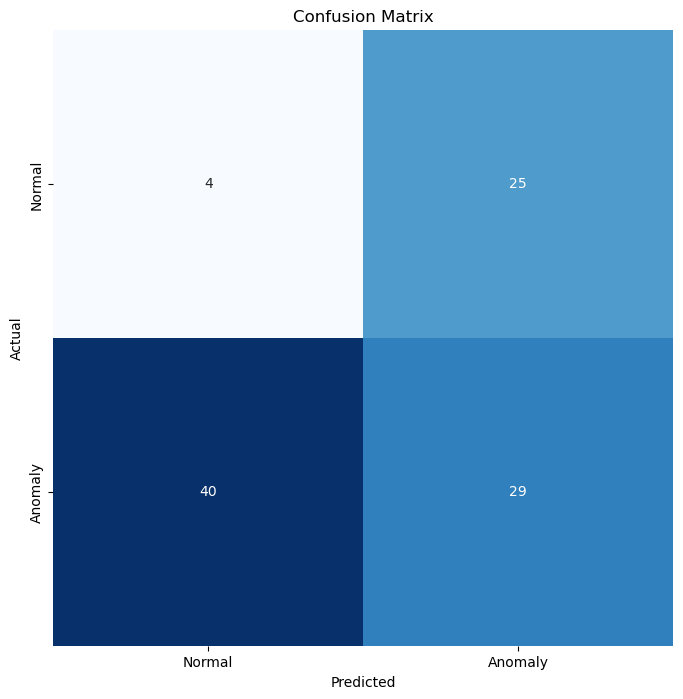

Classification Report:
               precision    recall  f1-score   support

      Normal       0.09      0.14      0.11        29
     Anomaly       0.54      0.42      0.47        69

    accuracy                           0.34        98
   macro avg       0.31      0.28      0.29        98
weighted avg       0.41      0.34      0.36        98



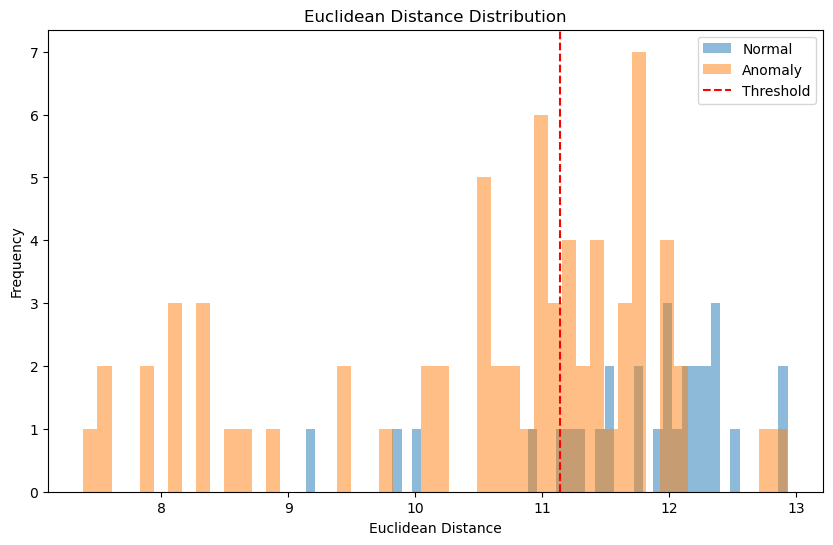

In [23]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Latent Space Threshold Calculation
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)
val_images, _ = next(validation_generator)
val_latents = encoder.predict(val_images)
mean_latent = np.mean(val_latents, axis=0)
val_scores = np.linalg.norm(val_latents - mean_latent, axis=1)
threshold = np.percentile(val_scores, config["threshold_percentage"])
print(f"Threshold Value (Percentile {config['threshold_percentage']}%): {threshold}")

# Anomaly Detection on Test Data
def evaluate_on_test_data(generator, encoder, mean_latent, threshold):
    test_images = []
    test_labels = []

    # Loop through the generator to collect all test images and labels
    for i in range(len(generator)):
        images, labels = next(generator)
        test_images.append(images)
        test_labels.append(labels)

    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels)

    test_latents = encoder.predict(test_images)
    test_scores = np.linalg.norm(test_latents - mean_latent, axis=1)
    predictions = test_scores > threshold

    # Map labels to binary (0 for normal, 1 for anomaly)
    binary_labels = (np.argmax(test_labels, axis=1) != 0).astype(int)

    return test_images, binary_labels, predictions, test_scores

test_images, binary_labels, predictions,test_scores = evaluate_on_test_data(test_generator, encoder, mean_latent, threshold)

# Confusion Matrix
cm = confusion_matrix(binary_labels, predictions, labels=[0, 1])  # 0: normal, 1: anomaly
labels = ["Normal", "Anomaly"]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(binary_labels, predictions, target_names=["Normal", "Anomaly"])
print("Classification Report:\n", report)




def plot_distance_distribution(scores, binary_labels, threshold, metric_name="Distance"):
    """
    Plots the distribution of distances for normal and anomalous samples.
    
    Args:
        scores (list): List of distance scores.
        binary_labels (list): Binary labels (0 for normal, 1 for anomaly).
        threshold (float): Threshold used for anomaly detection.
        metric_name (str): Name of the metric (e.g., 'Euclidean Distance', 'Mahalanobis Distance').
    """
    plt.figure(figsize=(10, 6))
    plt.hist([scores[i] for i in range(len(scores)) if binary_labels[i] == 0], 
             bins=50, alpha=0.5, label='Normal')
    plt.hist([scores[i] for i in range(len(scores)) if binary_labels[i] == 1], 
             bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title(f"{metric_name} Distribution")
    plt.xlabel(metric_name)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot distribution of Mahalanobis distances
plot_distance_distribution(test_scores, binary_labels, threshold, metric_name="Euclidean Distance")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Threshold Value (Percentile 80%): 1866.046175609295
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


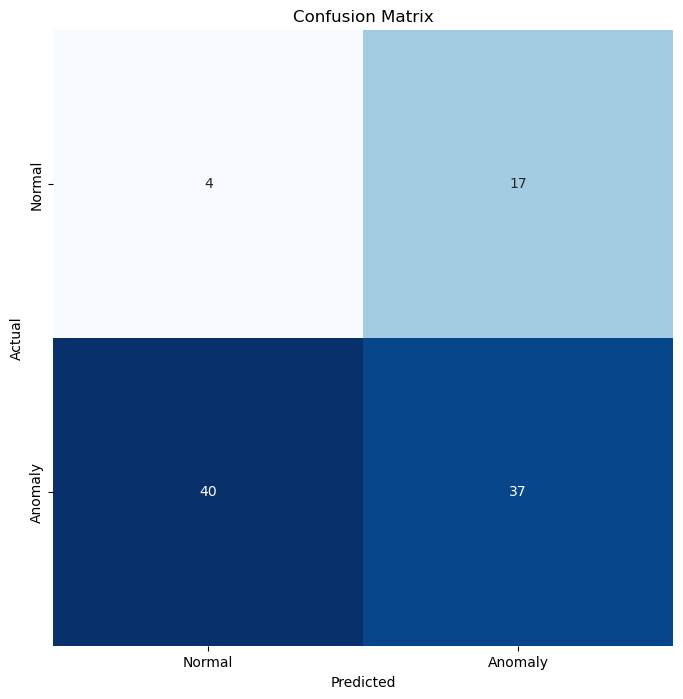

Classification Report:
               precision    recall  f1-score   support

      Normal       0.09      0.19      0.12        21
     Anomaly       0.69      0.48      0.56        77

    accuracy                           0.42        98
   macro avg       0.39      0.34      0.34        98
weighted avg       0.56      0.42      0.47        98



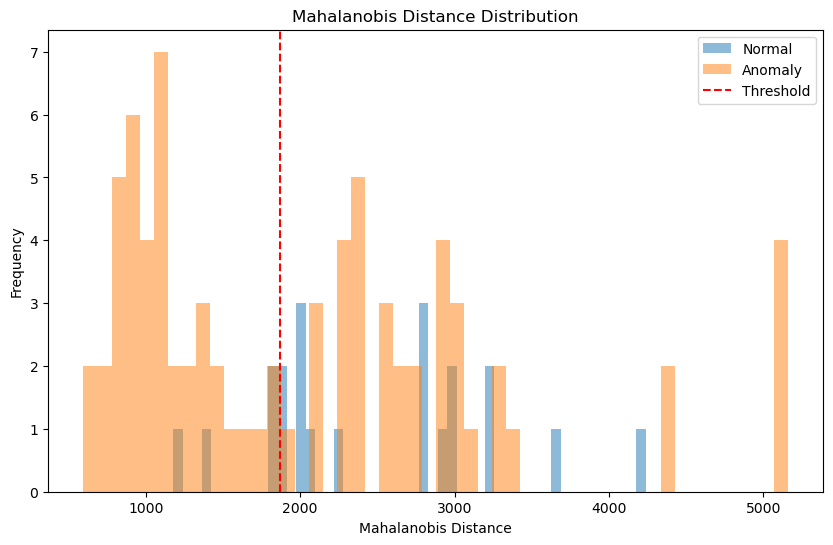

In [29]:
from scipy.spatial.distance import mahalanobis

# Latent Space Threshold Calculation with Mahalanobis Distance
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)
val_images, _ = next(validation_generator)
val_latents = encoder.predict(val_images)
mean_latent = np.mean(val_latents, axis=0)
# Regularize covariance matrix
epsilon = 1e-6
cov_matrix += np.eye(cov_matrix.shape[0]) * epsilon

# Recalculate inverse covariance matrix
cov_matrix_inv = np.linalg.inv(cov_matrix)

# Validate latent vectors
if np.isnan(val_latents).any() or np.isinf(val_latents).any():
    raise ValueError("NaN or Inf detected in validation latent vectors. Check data preprocessing and model.")

# Calculate Mahalanobis distances
val_scores = [mahalanobis(latent, mean_latent, cov_matrix_inv) for latent in val_latents]

# Calculate threshold
if not val_scores or np.isnan(val_scores).any():
    raise ValueError("NaN detected in Mahalanobis distances. Check covariance matrix and latent vectors.")

threshold = np.percentile(val_scores, config["threshold_percentage"])
print(f"Threshold Value (Percentile {config['threshold_percentage']}%): {threshold}")


# Anomaly Detection on Test Data using Mahalanobis Distance
def evaluate_on_test_data_mahalanobis(generator, encoder, mean_latent, cov_matrix_inv, threshold):
    test_images = []
    test_labels = []

    # Loop through the generator to collect all test images and labels
    for i in range(len(generator)):
        images, labels = next(generator)
        test_images.append(images)
        test_labels.append(labels)

    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels)

    test_latents = encoder.predict(test_images)
    test_scores = [mahalanobis(latent, mean_latent, cov_matrix_inv) for latent in test_latents]
    predictions = np.array(test_scores) > threshold

    # Map labels to binary (0 for normal, 1 for anomaly)
    binary_labels = (np.argmax(test_labels, axis=1) != 0).astype(int)

    return test_images, binary_labels, predictions, test_scores

test_images, binary_labels, predictions, test_scores = evaluate_on_test_data_mahalanobis(test_generator, encoder, mean_latent, cov_matrix_inv, threshold)

# Confusion Matrix
cm = confusion_matrix(binary_labels, predictions, labels=[0, 1])  # 0: normal, 1: anomaly
labels = ["Normal", "Anomaly"]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(binary_labels, predictions, target_names=["Normal", "Anomaly"])
print("Classification Report:\n", report)



def plot_distance_distribution(scores, binary_labels, threshold, metric_name="Distance"):
    """
    Plots the distribution of distances for normal and anomalous samples.
    
    Args:
        scores (list): List of distance scores.
        binary_labels (list): Binary labels (0 for normal, 1 for anomaly).
        threshold (float): Threshold used for anomaly detection.
        metric_name (str): Name of the metric (e.g., 'Euclidean Distance', 'Mahalanobis Distance').
    """
    plt.figure(figsize=(10, 6))
    plt.hist([scores[i] for i in range(len(scores)) if binary_labels[i] == 0], 
             bins=50, alpha=0.5, label='Normal')
    plt.hist([scores[i] for i in range(len(scores)) if binary_labels[i] == 1], 
             bins=50, alpha=0.5, label='Anomaly')
    plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
    plt.title(f"{metric_name} Distribution")
    plt.xlabel(metric_name)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot distribution of Mahalanobis distances
plot_distance_distribution(test_scores, binary_labels, threshold, metric_name="Mahalanobis Distance")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


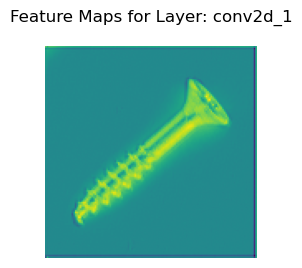

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


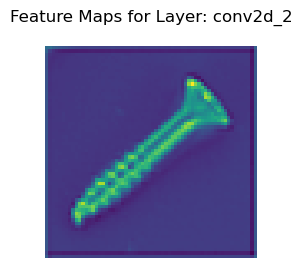

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


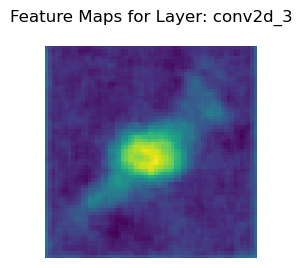

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


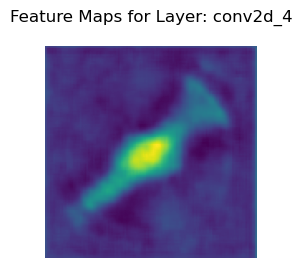

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


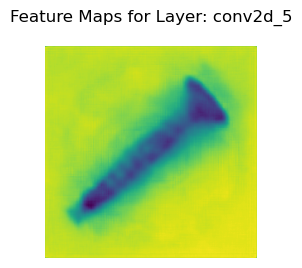

In [31]:
def plot_first_10_feature_maps(autoencoder, layer_name, input_image):
    """
    Visualize the first 10 feature maps for a specific layer of the autoencoder using original colors.
    
    Args:
        autoencoder (Model): The autoencoder model.
        layer_name (str): Name of the layer to visualize feature maps.
        input_image (numpy.ndarray): Input image to generate feature maps.
    """
    from tensorflow.keras.models import Model
    import matplotlib.pyplot as plt

    # Create a model that outputs feature maps for the specified layer
    layer_output = autoencoder.get_layer(name=layer_name).output
    feature_map_model = Model(inputs=autoencoder.input, outputs=layer_output)

    # Get feature maps
    feature_map = feature_map_model.predict(np.expand_dims(input_image, axis=0))

    # Normalize feature map values to [0, 1] for proper display
    feature_map -= feature_map.min()
    feature_map /= feature_map.max()

    # Limit to the first 10 feature maps
    num_filters = min(1, feature_map.shape[-1])

    # Plot feature maps
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Feature Maps for Layer: {layer_name}", fontsize=12)

    for i in range(num_filters):
        plt.subplot(2, num_filters, i + 1)
        plt.imshow(feature_map[0, :, :, i])  # Display original colors
        plt.axis('off')

    plt.subplots_adjust(top=0.85)  # Add space at the top of the figure
    plt.tight_layout()
    plt.show()

# Example Usage
sample_image = test_images[0]  # Use a sample test image
plot_first_10_feature_maps(autoencoder, 'conv2d_1', sample_image)
plot_first_10_feature_maps(autoencoder, 'conv2d_2', sample_image)
plot_first_10_feature_maps(autoencoder, 'conv2d_3', sample_image)
plot_first_10_feature_maps(autoencoder, 'conv2d_4', sample_image)
plot_first_10_feature_maps(autoencoder, 'conv2d_5', sample_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


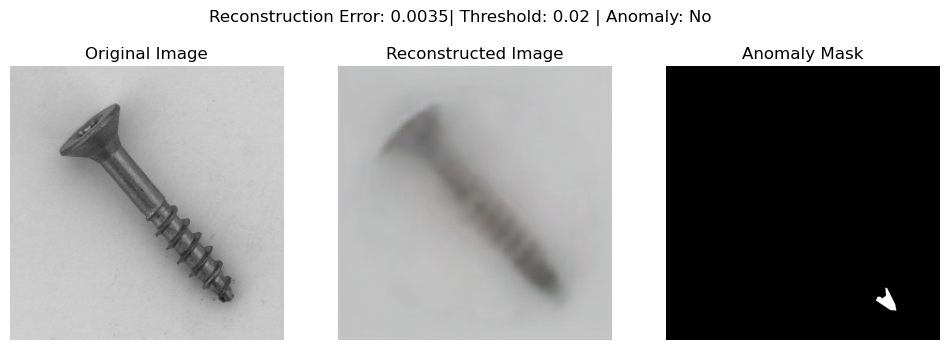

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


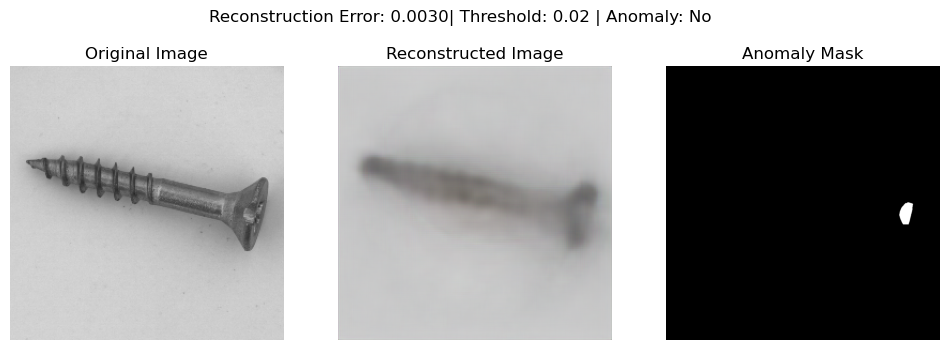

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


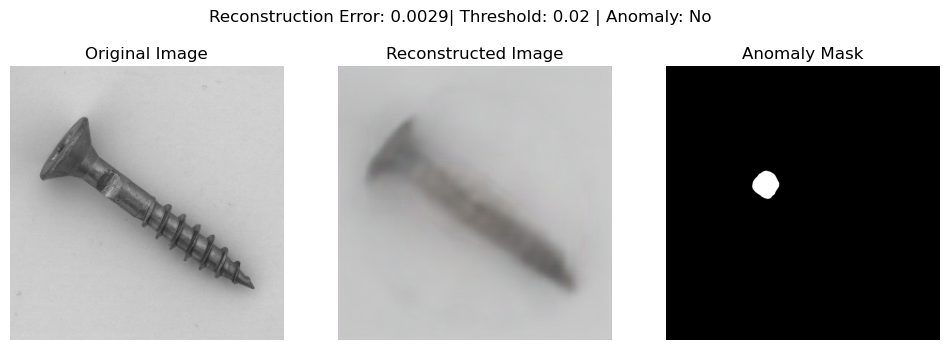

In [33]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess an image for the autoencoder."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0  # Normalize to [0, 1] and set to float32
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed images."""
    return np.mean((original - reconstructed) ** 2)

def predict_anomaly_and_plot(autoencoder, image_path, mask_dir, threshold=0.02):
    """
    Predict if an image is an anomaly based on reconstruction error
    and plot original, reconstructed, and mask images.
    
    Parameters:
        autoencoder (Model): The trained autoencoder model.
        image_path (str): Path to the image file.
        mask_dir (str): Directory containing anomaly mask images.
        threshold (float): Error threshold to classify as anomaly.
    
    Returns:
        bool: True if anomaly, False otherwise.
        float: The reconstruction error.
    """
    # Preprocess the image
    img = preprocess_image(image_path)
    
    # Reconstruct the image with the autoencoder
    reconstructed_img = autoencoder.predict(img)

    # Ensure reconstructed image is in float32 format
    reconstructed_img = reconstructed_img.astype('float32')
    
    # Calculate reconstruction error
    error = calculate_reconstruction_error(img, reconstructed_img)
    
    # Classify as anomaly if error exceeds the threshold
    is_anomaly = error > threshold

    # Generate the corresponding mask path
    file_name = os.path.basename(image_path).split('.')[0] + '_mask.png'
    label = os.path.basename(os.path.dirname(image_path))
    mask_path = os.path.join(mask_dir, label, file_name)
    
    # Load the mask image if it exists
    if os.path.exists(mask_path):
        mask_img = plt.imread(mask_path)
    else:
        mask_img = None

    # Plot original, reconstructed, and mask images
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img[0])  # Remove batch dimension for display
    plt.title("Original Image")
    plt.axis("off")
    
    # Reconstructed image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_img[0])  # Remove batch dimension for display
    plt.title("Reconstructed Image")
    plt.axis("off")
    
    # Anomaly mask
    plt.subplot(1, 3, 3)
    if mask_img is not None:
        plt.imshow(mask_img, cmap="gray")
        plt.title("Anomaly Mask")
    else:
        plt.text(0.5, 0.5, 'No Mask Available', ha='center', va='center', fontsize=12)
    plt.axis("off")
    
    plt.suptitle(f"Reconstruction Error: {error:.4f}| Threshold: {threshold} | Anomaly: {'Yes' if is_anomaly else 'No'}")
    plt.show()
    
    return is_anomaly, error

# Example usage
# Example usage
mask_dir = '../../data/screw/ground_truth'
image_paths = [
    '../../data/screw/test/manipulated_front/001.png',
    '../../data/screw/test/scratch_head/001.png', 
    '../../data/screw/test/scratch_neck/001.png' 
]
"""
mask_dir = 'data/screw/ground_truth'
image_paths = [
    'data/screw/test/manipulated_front/001.png',
    'data/screw/test/scratch_head/001.png', 
    'data/screw/test/scratch_neck/001.png' 
]"""
for path in image_paths: 
    is_anomaly, error = predict_anomaly_and_plot(autoencoder, path, mask_dir)
